In [1]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
from regrid import regrid
import itertools
import cartopy.crs as ccrs
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [2]:
datapath = '/Users/carmennab/Dropbox/met_office/data/experiments/FOAM_grid/'
ctrl = np.array(Dataset(datapath+'rosie_UCL_CTL_NOSIT_ASSIM_r243541_dcarneir.nc')['sivolu'])
base = np.array(Dataset(datapath+'rosie_UCL_BASELINE_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_r243541_dcarneir.nc')['sivolu'])
unc = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_NEW_OBERR_r243541_dcarneir.nc')['sivolu'])
### alpha
nine = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA09_r243541_dcarneir.nc')['sivolu'])
six = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA06_r243541_dcarneir.nc')['sivolu'])
### retracker
larm = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_BRISTOL_SNFOAM_ALPHA1_r243541_dcarneir.nc')['sivolu'])
cpom = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_CPOM_SNFOAM_ALPHA1_r243541_dcarneir.nc')['sivolu'])
### snow
smlg = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNLG_ALPHA1_r243541_dcarneir.nc')['sivolu'])
awi = np.array(Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNAWI_ALPHA1_r243541_dcarneir.nc')['sivolu'])

In [3]:
foam_lats = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lat_cent.npy')
foam_lons = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lon_cent.npy')

sits = [ctrl,base,nine,six,larm,cpom,smlg,awi,unc]
names = ['CTRL','BASE','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC']

In [4]:
means = {}

for name, sit in zip(names,sits):
    means[name] = np.nanmean(sit,axis = 0)
    
stdevs = []
for name in names[1:]:
    stdevs.append(means[name])
means['STDEV'] = np.std(stdevs,axis = 0)

In [5]:
perc_diff = (unc-base/base)*100
perc_diff[np.isinf(perc_diff)]=np.nan
np.nanmean(perc_diff)

-36.14076249385252

### plot runs - base

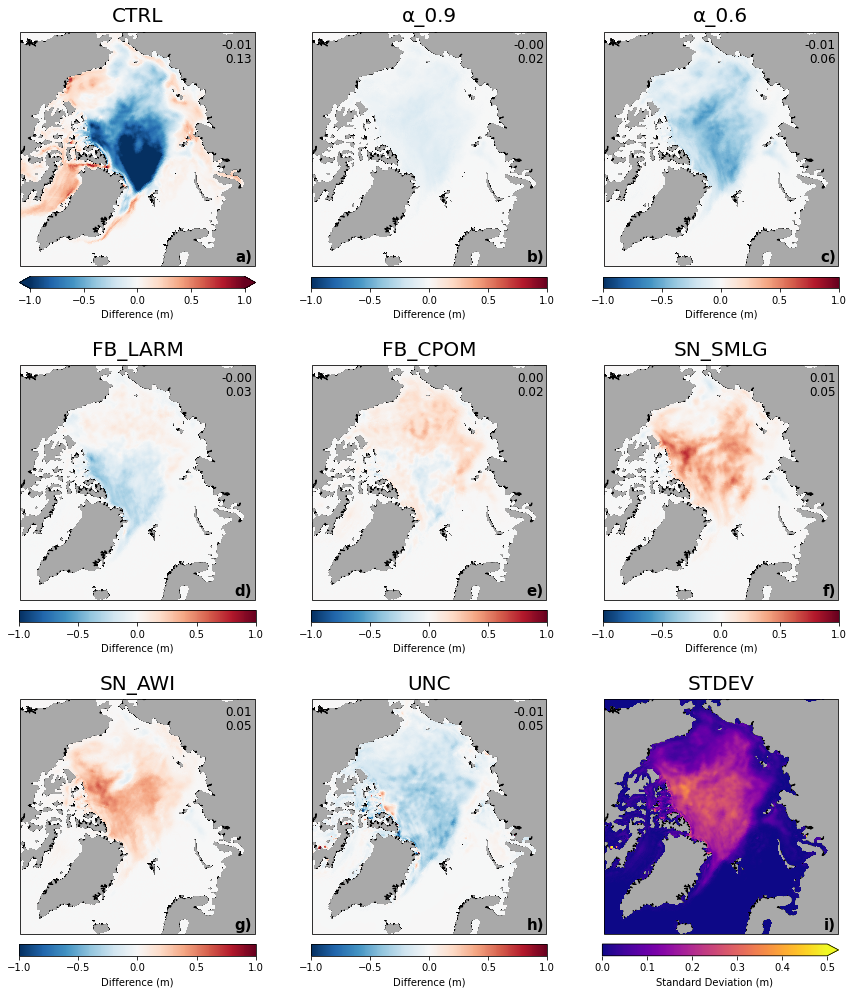

In [6]:
fig = plt.figure(figsize=(15,17))
spec = gridspec.GridSpec(ncols=3, nrows=3, hspace=0.3, wspace=0.15)

names = ['CTRL','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC','STDEV']
nums = ['a)','b)','c)','d)','e)','f)','g)','h)','i)']

for count, name in enumerate(names):
    
    ax = fig.add_subplot(spec[count],projection=ccrs.NorthPolarStereo())
    ax.set_extent([-180, 180, 90, 65], ccrs.PlateCarree())
    ax.add_feature(cartopy.feature.LAND, color='darkgrey',zorder=1)
    ax.coastlines()
    ax.set_title(name, fontsize=20, pad=10)   
    if count == 8:
        p_map = ax.pcolormesh(foam_lons,foam_lats,means[name][:-1,:-1],cmap='plasma',vmin=0,vmax=0.5,
                              transform=ccrs.PlateCarree()) 
        a = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04,extend='max') 
        a.set_label('Standard Deviation (m)',fontsize='medium')  
    else:
        p_map = ax.pcolormesh(foam_lons,foam_lats,means[name][:-1,:-1]-means['BASE'][:-1,:-1],cmap='RdBu_r',vmin=-1,
                              vmax=1,transform=ccrs.PlateCarree()) 
        if count == 0:
            a = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04, extend = 'both') 
        else:
            a = plt.colorbar(p_map,location="bottom",fraction=0.046, pad=0.04) 
        a.set_label('Difference (m)',fontsize='medium')  

        ax.text(0.99, 0.93, f"{np.nanmean(means[name][:-1,:-1]-means['BASE'][:-1,:-1]):.2f}", fontsize=12, ha= 'right', 
                transform = ax.transAxes)    
        ax.text(0.99, 0.87, f"{np.nanstd(means[name][:-1,:-1]-means['BASE'][:-1,:-1]):.2f}", fontsize=12, ha= 'right', 
                transform = ax.transAxes)
    ax.text(0.99, 0.02, nums[count], fontsize=15, ha= 'right', transform = ax.transAxes,fontweight='bold')
    
plt.savefig('/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/main_figs/runs_vs_base.png',dpi=400, 
            bbox_inches="tight")